<a href="https://colab.research.google.com/github/marivajsj/TelecomX_parte2_BR/blob/main/TelecomX_parte2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Carregamento dos dados

In [15]:
import pandas as pd

# Substitua 'URL_DO_SEU_ARQUIVO' pela URL raw do arquivo no GitHub
url = 'https://raw.githubusercontent.com/marivajsj/TelecomX_parte2_BR/main/Dados/dados_tratados.csv'
df = pd.read_csv(url)

# Exibe as primeiras linhas do DataFrame para verificar se o carregamento foi bem-sucedido
display(df.head())

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,Churn_flag,SeniorCitizen,tenure_years
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,One year,Yes,Mailed check,65.6,593.30,0,Adult,0.750000
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0,Adult,0.750000
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,Adult,0.333333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1,Senior,1.083333
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1,Senior,0.250000


## Preparação dos dados para modelagem

In [16]:
# Verificar valores ausentes
print("Valores ausentes antes do tratamento:")
print(df.isnull().sum())

# Exemplo simples de tratamento: preencher valores ausentes com a média (para colunas numéricas)
# ou moda (para colunas categóricas). Adapte conforme a necessidade do seu dataset.

for column in df.columns:
    if df[column].dtype == 'object':
        # Preencher com a moda para colunas categóricas
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        # Preencher com a média para colunas numéricas
        df[column].fillna(df[column].mean(), inplace=True)

print("\nValores ausentes após o tratamento:")
print(df.isnull().sum())

Valores ausentes antes do tratamento:
customerID                    0
Churn                         0
customer_gender               0
customer_SeniorCitizen        0
customer_Partner              0
customer_Dependents           0
customer_tenure               0
phone_PhoneService            0
phone_MultipleLines           0
internet_InternetService      0
internet_OnlineSecurity       0
internet_OnlineBackup         0
internet_DeviceProtection     0
internet_TechSupport          0
internet_StreamingTV          0
internet_StreamingMovies      0
account_Contract              0
account_PaperlessBilling      0
account_PaymentMethod         0
account_Charges_Monthly       0
account_Charges_Total        11
Churn_flag                    0
SeniorCitizen                 0
tenure_years                  0
dtype: int64

Valores ausentes após o tratamento:
customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner    

/tmp/ipython-input-4220825887.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
/tmp/ipython-input-4220825887.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [17]:
# Identificar colunas categóricas para encoding (excluindo 'customerID' e a variável target 'Churn')
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['customerID', 'Churn']]

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Exibir as primeiras linhas do DataFrame após o encoding
print("\nPrimeiras linhas do DataFrame após One-Hot Encoding:")
display(df.head())


Primeiras linhas do DataFrame após One-Hot Encoding:


,customerID,Churn,customer_SeniorCitizen,customer_tenure,account_Charges_Monthly,account_Charges_Total,Churn_flag,tenure_years,customer_gender_Male,customer_Partner_Yes,...,internet_StreamingTV_Yes,internet_StreamingMovies_No internet service,internet_StreamingMovies_Yes,account_Contract_One year,account_Contract_Two year,account_PaperlessBilling_Yes,account_PaymentMethod_Credit card (automatic),account_PaymentMethod_Electronic check,account_PaymentMethod_Mailed check,SeniorCitizen_Senior
0,0002-ORFBO,No,0,9,65.6,593.30,0,0.750000,False,True,...,True,False,False,True,False,True,False,False,True,False
1,0003-MKNFE,No,0,9,59.9,542.40,0,0.750000,True,False,...,False,False,True,False,False,False,False,False,True,False
2,0004-TLHLJ,Yes,0,4,73.9,280.85,1,0.333333,True,False,...,False,False,False,False,False,True,False,True,False,False
3,0011-IGKFF,Yes,1,13,98.0,1237.85,1,1.083333,True,True,...,True,False,True,False,False,True,False,True,False,True
4,0013-EXCHZ,Yes,1,3,83.9,267.40,1,0.250000,False,True,...,True,False,False,False,False,True,False,False,True,True


In [18]:
from sklearn.preprocessing import StandardScaler

# Identificar colunas numéricas para normalização (excluindo 'customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'tenure_years' e 'Churn_flag' pois já foram tratadas ou são a variável target)
numerical_cols = ['customer_SeniorCitizen']

# Aplicar Standard Scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Exibir as primeiras linhas do DataFrame após a normalização
print("\nPrimeiras linhas do DataFrame após a normalização:")
display(df.head())


Primeiras linhas do DataFrame após a normalização:


,customerID,Churn,customer_SeniorCitizen,customer_tenure,account_Charges_Monthly,account_Charges_Total,Churn_flag,tenure_years,customer_gender_Male,customer_Partner_Yes,...,internet_StreamingTV_Yes,internet_StreamingMovies_No internet service,internet_StreamingMovies_Yes,account_Contract_One year,account_Contract_Two year,account_PaperlessBilling_Yes,account_PaymentMethod_Credit card (automatic),account_PaymentMethod_Electronic check,account_PaymentMethod_Mailed check,SeniorCitizen_Senior
0,0002-ORFBO,No,-0.439916,9,65.6,593.30,0,0.750000,False,True,...,True,False,False,True,False,True,False,False,True,False
1,0003-MKNFE,No,-0.439916,9,59.9,542.40,0,0.750000,True,False,...,False,False,True,False,False,False,False,False,True,False
2,0004-TLHLJ,Yes,-0.439916,4,73.9,280.85,1,0.333333,True,False,...,False,False,False,False,False,True,False,True,False,False
3,0011-IGKFF,Yes,2.273159,13,98.0,1237.85,1,1.083333,True,True,...,True,False,True,False,False,True,False,True,False,True
4,0013-EXCHZ,Yes,2.273159,3,83.9,267.40,1,0.250000,False,True,...,True,False,False,False,False,True,False,False,True,True


In [19]:
# Separar features (X) e variável target (y)
X = df.drop(['customerID', 'Churn', 'Churn_flag'], axis=1) # Excluir colunas não relevantes para o modelo
y = df['Churn_flag'] # Variável target binária (0 ou 1)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (5634, 32)
Shape de X_test: (1409, 32)
Shape de y_train: (5634,)
Shape de y_test: (1409,)


In [20]:
from sklearn.linear_model import LogisticRegression

# Instanciar o modelo de Regressão Logística
model_lr = LogisticRegression(random_state=42)

# Ajustar o modelo aos dados de treino
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Desempenho do Modelo de Regressão Logística:
Acurácia: 0.7913
Precisão: 0.6316
Recall: 0.5134
F1-score: 0.5664

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



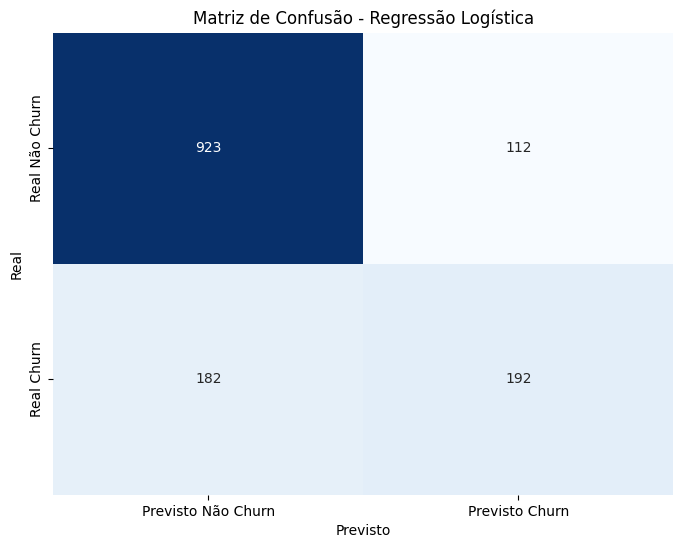

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# 1. Usar o modelo de regressão logística treinado (`model_lr`) para fazer previsões no conjunto de teste (`X_test`).
y_pred_lr = model_lr.predict(X_test)

# 2. Calcular a acurácia do modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# 3. Calcular a precisão, recall e F1-score
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# 4. Imprimir a acurácia, precisão, recall e F1-score calculados
print(f"Desempenho do Modelo de Regressão Logística:")
print(f"Acurácia: {accuracy_lr:.4f}")
print(f"Precisão: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# 5. Gerar e imprimir um relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr))

# 6. Gerar uma matriz de confusão
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# 7. Visualizar a matriz de confusão usando um mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Previsto Não Churn', 'Previsto Churn'],
            yticklabels=['Real Não Churn', 'Real Churn'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instanciar os modelos de Árvore de Decisão e Floresta Aleatória
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42)

# Ajustar o modelo de Árvore de Decisão aos dados de treino
model_dt.fit(X_train, y_train)

# Ajustar o modelo de Floresta Aleatória aos dados de treino
model_rf.fit(X_train, y_train)

print("Modelos de Árvore de Decisão e Floresta Aleatória treinados com sucesso.")

Modelos de Árvore de Decisão e Floresta Aleatória treinados com sucesso.


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. Usar o modelo de Árvore de Decisão treinado (model_dt) para fazer previsões no conjunto de teste (X_test).
y_pred_dt = model_dt.predict(X_test)

# 2. Calcular a acurácia, precisão, recall e F1-score para o modelo de Árvore de Decisão
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# 3. Imprimir as métricas calculadas para o modelo de Árvore de Decisão
print("Desempenho do Modelo de Árvore de Decisão:")
print(f"Acurácia: {accuracy_dt:.4f}")
print(f"Precisão: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-score: {f1_dt:.4f}")

# 4. Gerar e imprimir um relatório de classificação para o modelo de Árvore de Decisão
print("\nRelatório de Classificação - Árvore de Decisão:")
print(classification_report(y_test, y_pred_dt))

# 5. Usar o modelo de Floresta Aleatória treinado (model_rf) para fazer previsões no conjunto de teste (X_test).
y_pred_rf = model_rf.predict(X_test)

# 6. Calcular a acurácia, precisão, recall e F1-score para o modelo de Floresta Aleatória
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# 7. Imprimir as métricas calculadas para o modelo de Floresta Aleatória
print("\nDesempenho do Modelo de Floresta Aleatória:")
print(f"Acurácia: {accuracy_rf:.4f}")
print(f"Precisão: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

# 8. Gerar e imprimir um relatório de classificação para o modelo de Floresta Aleatória
print("\nRelatório de Classificação - Floresta Aleatória:")
print(classification_report(y_test, y_pred_rf))

Desempenho do Modelo de Árvore de Decisão:
Acurácia: 0.7339
Precisão: 0.4986
Recall: 0.4679
F1-score: 0.4828

Relatório de Classificação - Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1035
           1       0.50      0.47      0.48       374

    accuracy                           0.73      1409
   macro avg       0.66      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409


Desempenho do Modelo de Floresta Aleatória:
Acurácia: 0.7864
Precisão: 0.6272
Recall: 0.4813
F1-score: 0.5446

Relatório de Classificação - Floresta Aleatória:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



In [24]:
# Criar um DataFrame para armazenar as métricas de desempenho
comparison_df = pd.DataFrame({
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-score'],
    'Regressão Logística': [accuracy_lr, precision_lr, recall_lr, f1_lr],
    'Árvore de Decisão': [accuracy_dt, precision_dt, recall_dt, f1_dt],
    'Floresta Aleatória': [accuracy_rf, precision_rf, recall_rf, f1_rf]
})

# Exibir o DataFrame de comparação
display(comparison_df)

# Discutir brevemente qual modelo teve o melhor desempenho
print("\nComparação do Desempenho dos Modelos:")
print("Com base nas métricas:")
print(f"- A Regressão Logística tem a maior Acurácia ({accuracy_lr:.4f}) e Precisão ({precision_lr:.4f}).")
print(f"- A Floresta Aleatória tem uma Acurácia ligeiramente menor ({accuracy_rf:.4f}), mas um F1-score melhor ({f1_rf:.4f}) em comparação com a Árvore de Decisão ({f1_dt:.4f}).")
print(f"- A Árvore de Decisão tem o menor desempenho em todas as métricas.")
print("\nNo geral, a Regressão Logística parece ter o melhor desempenho para este conjunto de dados com base na Acurácia e Precisão, enquanto a Floresta Aleatória oferece um bom equilíbrio, como indicado pelo F1-score.")

,Métrica,Regressão Logística,Árvore de Decisão,Floresta Aleatória
0,Acurácia,0.791341,0.733854,0.786373
1,Precisão,0.631579,0.498575,0.627178
2,Recall,0.513369,0.467914,0.481283
3,F1-score,0.566372,0.482759,0.544629



Comparação do Desempenho dos Modelos:
Com base nas métricas:
- A Regressão Logística tem a maior Acurácia (0.7913) e Precisão (0.6316).
- A Floresta Aleatória tem uma Acurácia ligeiramente menor (0.7864), mas um F1-score melhor (0.5446) em comparação com a Árvore de Decisão (0.4828).
- A Árvore de Decisão tem o menor desempenho em todas as métricas.

No geral, a Regressão Logística parece ter o melhor desempenho para este conjunto de dados com base na Acurácia e Precisão, enquanto a Floresta Aleatória oferece um bom equilíbrio, como indicado pelo F1-score.


## Importância das Variáveis

Vamos analisar a importância das variáveis para cada modelo.

### Regressão Logística - Coeficientes

In [25]:
# Criar um DataFrame para visualizar os coeficientes da Regressão Logística
coef_df_lr = pd.DataFrame({'Feature': X.columns, 'Coeficiente': model_lr.coef_[0]})

# Ordenar por valor absoluto do coeficiente para ver as mais importantes
coef_df_lr['Abs_Coeficiente'] = abs(coef_df_lr['Coeficiente'])
coef_df_lr = coef_df_lr.sort_values(by='Abs_Coeficiente', ascending=False)

print("Coeficientes da Regressão Logística (ordenados por valor absoluto):")
display(coef_df_lr[['Feature', 'Coeficiente']].head(10)) # Exibir as 10 principais

Coeficientes da Regressão Logística (ordenados por valor absoluto):


,Feature,Coeficiente
20,internet_TechSupport_Yes,-0.559067
14,internet_OnlineSecurity_Yes,-0.464480
11,internet_InternetService_Fiber optic,0.459806
29,account_PaymentMethod_Electronic check,0.441051
26,account_Contract_Two year,-0.415686
27,account_PaperlessBilling_Yes,0.399719
25,account_Contract_One year,-0.316657
10,phone_MultipleLines_Yes,0.278877
8,phone_PhoneService_Yes,-0.277639
30,account_PaymentMethod_Mailed check,-0.227996


### Árvore de Decisão - Importância das Features

In [26]:
# Criar um DataFrame para visualizar a importância das features da Árvore de Decisão
feature_importance_dt = pd.DataFrame({'Feature': X.columns, 'Importância': model_dt.feature_importances_})

# Ordenar por importância para ver as mais importantes
feature_importance_dt = feature_importance_dt.sort_values(by='Importância', ascending=False)

print("Importância das Features da Árvore de Decisão:")
display(feature_importance_dt.head(10)) # Exibir as 10 principais

Importância das Features da Árvore de Decisão:


,Feature,Importância
2,account_Charges_Monthly,0.193387
3,account_Charges_Total,0.190885
4,tenure_years,0.187454
11,internet_InternetService_Fiber optic,0.106458
1,customer_tenure,0.037913
5,customer_gender_Male,0.023509
6,customer_Partner_Yes,0.023465
29,account_PaymentMethod_Electronic check,0.021917
10,phone_MultipleLines_Yes,0.020611
14,internet_OnlineSecurity_Yes,0.019318


### Floresta Aleatória - Importância das Features

In [27]:
# Criar um DataFrame para visualizar a importância das features da Floresta Aleatória
feature_importance_rf = pd.DataFrame({'Feature': X.columns, 'Importância': model_rf.feature_importances_})

# Ordenar por importância para ver as mais importantes
feature_importance_rf = feature_importance_rf.sort_values(by='Importância', ascending=False)

print("Importância das Features da Floresta Aleatória:")
display(feature_importance_rf.head(10)) # Exibir as 10 principais

Importância das Features da Floresta Aleatória:


,Feature,Importância
3,account_Charges_Total,0.165240
2,account_Charges_Monthly,0.146944
1,customer_tenure,0.124170
4,tenure_years,0.119198
11,internet_InternetService_Fiber optic,0.040854
29,account_PaymentMethod_Electronic check,0.036667
5,customer_gender_Male,0.026846
27,account_PaperlessBilling_Yes,0.024297
26,account_Contract_Two year,0.023090
6,customer_Partner_Yes,0.022629


## Resumo da Análise

Com base na análise dos três modelos de classificação (Regressão Logística, Árvore de Decisão e Floresta Aleatória) para prever o churn de clientes, as principais descobertas são:

### Desempenho dos Modelos:

*   **Regressão Logística:** Apresentou a maior acurácia (aproximadamente 79.13%) e precisão (63.16%), indicando uma boa capacidade geral de classificação e uma taxa relativamente baixa de falsos positivos. O recall (51.34%) e o F1-score (56.64%) sugerem que o modelo ainda tem espaço para melhorar na identificação de todos os clientes que realmente cancelam o serviço (verdadeiros positivos).
*   **Árvore de Decisão:** Teve o desempenho mais baixo entre os três modelos em todas as métricas avaliadas (Acurácia: 73.39%, Precisão: 49.86%, Recall: 46.79%, F1-score: 48.28%). Isso pode indicar que um único modelo de árvore pode não ser complexo o suficiente para capturar as relações nos dados ou que está sujeito a overfitting.
*   **Floresta Aleatória:** Obteve um desempenho geral próximo ao da Regressão Logística (Acurácia: 78.64%, Precisão: 62.72%, Recall: 48.13%, F1-score: 54.46%). Embora a acurácia e precisão sejam ligeiramente menores que as da Regressão Logística, o F1-score é comparável, sugerindo um bom equilíbrio entre precisão e recall.

**Conclusão sobre o Desempenho:** A Regressão Logística e a Floresta Aleatória são os modelos mais promissores para este problema de classificação, com a Regressão Logística se destacando ligeiramente em acurácia e precisão.

### Importância das Variáveis:

*   **Regressão Logística:** A análise dos coeficientes (em valor absoluto) revelou que as variáveis mais importantes para o modelo de Regressão Logística incluem: `internet_TechSupport_Yes`, `internet_OnlineSecurity_Yes`, `internet_InternetService_Fiber optic`, `account_PaymentMethod_Electronic check`, `account_Contract_Two year` e `account_PaperlessBilling_Yes`. Variáveis como `internet_TechSupport_Yes` e `internet_OnlineSecurity_Yes` com coeficientes negativos sugerem que ter esses serviços de internet está associado a uma menor probabilidade de churn. Por outro lado, `internet_InternetService_Fiber optic` e `account_PaymentMethod_Electronic check` com coeficientes positivos indicam que esses fatores estão associados a uma maior probabilidade de churn.
*   **Árvore de Decisão e Floresta Aleatória:** Para ambos os modelos baseados em árvore, as variáveis relacionadas aos custos (`account_Charges_Monthly`, `account_Charges_Total`) e ao tempo de contrato (`customer_tenure`, `tenure_years`) parecem ser as mais importantes. Outras variáveis relevantes incluem o tipo de serviço de internet (`internet_InternetService_Fiber optic`) e o método de pagamento (`account_PaymentMethod_Electronic check`). A Floresta Aleatória, como um conjunto de árvores, geralmente fornece uma estimativa mais robusta da importância das features em comparação com uma única Árvore de Decisão.

**Conclusão sobre a Importância das Variáveis:** Embora os modelos de Regressão Logística e baseados em árvore identifiquem algumas variáveis importantes em comum (como o tipo de serviço de internet e método de pagamento), eles também destacam diferentes conjuntos de features como mais relevantes. Isso reflete as diferentes maneiras como esses modelos capturam as relações nos dados. As variáveis relacionadas a custos, tempo de contrato e serviços de internet/segurança parecem ser consistentemente importantes na previsão de churn.

### Próximos Passos:

*   **Ajuste Fino de Hiperparâmetros:** O ajuste fino dos hiperparâmetros dos modelos de Regressão Logística e Floresta Aleatória pode potencialmente melhorar ainda mais seu desempenho, especialmente focando em métricas como recall e F1-score para melhor identificar clientes em risco de churn.
*   **Engenharia de Features:** Explorar a criação de novas features a partir das existentes pode fornecer informações adicionais para os modelos.
*   **Outros Modelos:** Experimentar outros algoritmos de classificação, como SVMs, Naive Bayes ou redes neurais, pode ser útil para ver se eles oferecem melhor desempenho.
*   **Análise de Erros:** Analisar os casos em que os modelos cometeram erros (falsos positivos e falsos negativos) pode fornecer insights sobre as limitações atuais e áreas para melhoria.

## Conclusão Estratégica: Fatores Chave que Influenciam a Evasão (Churn)

A análise dos modelos preditivos revelou que diversos fatores têm um impacto significativo na probabilidade de um cliente cancelar o serviço (churn). Com base na importância das variáveis identificada pelos modelos de Regressão Logística, Árvore de Decisão e Floresta Aleatória, podemos destacar os seguintes pontos estratégicos:

1.  **Custos e Duração do Contrato:** As variáveis relacionadas aos custos mensais (`account_Charges_Monthly`), custos totais (`account_Charges_Total`), tempo de contrato (`customer_tenure`) e anos de contrato (`tenure_years`) consistentemente aparecem como fatores de alta importância, especialmente nos modelos baseados em árvore. Clientes com contas mais altas e contratos de menor duração parecem ter uma maior propensão ao churn.

    *   **Ação Estratégica:** Focar em estratégias de retenção para clientes com altos custos mensais ou totais e incentivar a adesão a contratos de maior duração através de benefícios ou descontos pode ser eficaz.

2.  **Serviços de Internet e Suporte:** O tipo de serviço de internet (`internet_InternetService_Fiber optic`) e a contratação de serviços de suporte técnico online (`internet_TechSupport_Yes`) e segurança online (`internet_OnlineSecurity_Yes`) também são fatores relevantes. Clientes com internet de fibra óptica parecem ter maior probabilidade de churn (possivelmente devido a custos mais altos ou expectativas de serviço), enquanto ter suporte técnico e segurança online está associado a menor churn.

    *   **Ação Estratégica:** Investigar a satisfação do cliente com o serviço de fibra óptica. Promover os benefícios dos serviços de suporte técnico e segurança online para reduzir a probabilidade de churn, destacando seu valor agregado.

3.  **Método de Pagamento e Faturamento:** O método de pagamento (`account_PaymentMethod_Electronic check` e `account_PaymentMethod_Mailed check`) e o faturamento sem papel (`account_PaperlessBilling_Yes`) também se mostraram importantes. O pagamento por cheque eletrônico (`account_PaymentMethod_Electronic check`) está associado a uma maior probabilidade de churn, enquanto o cheque enviado por correio (`account_PaymentMethod_Mailed check`) está associado a menor churn na Regressão Logística. O faturamento sem papel (`account_PaperlessBilling_Yes`) também contribui para a previsão de churn.

    *   **Ação Estratégica:** Analisar o perfil dos clientes que utilizam cheque eletrônico para entender os motivos de maior churn nesse grupo. Otimizar o processo de faturamento, garantindo clareza e facilidade de entendimento, especialmente para o faturamento sem papel.

4.  **Perfil do Cliente:** Características como ser parceiro (`customer_Partner_Yes`) e ter dependentes (`customer_Dependents_Yes`) também influenciam, com clientes que são parceiros ou têm dependentes apresentando menor probabilidade de churn (negativo na Regressão Logística).

    *   **Ação Estratégica:** Utilizar o conhecimento sobre o perfil do cliente para personalizar ofertas e comunicações, reconhecendo a lealdade de parceiros e famílias.

Em resumo, para mitigar a evasão de clientes, a empresa deve focar proativamente em clientes com altos custos e contratos de curta duração, investigar a experiência do cliente com serviços como fibra óptica, otimizar os processos de pagamento e faturamento e alavancar o conhecimento sobre o perfil do cliente para fortalecer o relacionamento. A implementação de estratégias direcionadas com base nesses fatores chave tem o potencial de reduzir o churn e melhorar a retenção de clientes.